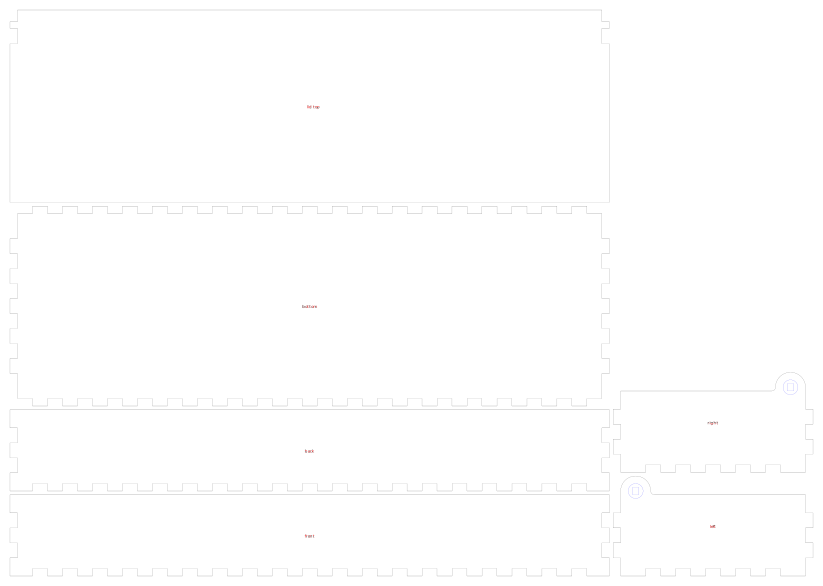

In [5]:
from boxes import *
from IPython.display import SVG, display
import io
import sys

sys.path.append('..')  # uncomments and adjust if your Boxes.py copy in not in the Python path
from boxes import *
from boxes import lids
from boxes.edges import Bolts
from boxes.lids import _TopEdge
import numpy as np


class MyBox(_TopEdge):
    """Box with various options for different styles and lids"""

    ui_group = "Box"

    def __init__(self) -> None:
        Boxes.__init__(self)
        self.addTopEdgeSettings(roundedtriangle={"outset" : 1},
                                hinge={"outset" : True})
        self.addSettingsArgs(edges.FlexSettings)
        self.addSettingsArgs(lids.LidSettings)
        self.buildArgParser("top_edge", "bottom_edge",
                            "x", "y", "h", "outside")
        self.argparser.add_argument(
            "--vertical_edges",  action="store", type=str,
            default="finger joints",
            choices=("finger joints", "finger holes"),
            help="connections used for the vertical edges")

    def drawLid(self, x: float, y: float, top_edge, bedBolts=[None, None]) -> bool:
        d2, d3 = bedBolts
        if top_edge == "c":
            self.rectangularWall(x, y, "CCCC", bedBolts=[d2, d3, d2, d3], move="up", label="top")
        elif top_edge == "f":
            self.rectangularWall(x, y, "FFFF", move="up", label="top")
        elif top_edge in "FhŠY":
            self.rectangularWall(x, y, "ffff", move="up", label="top")
        elif top_edge == "L":
            self.rectangularWall(x, y, "Enlm", move="up", label="lid top")
        elif top_edge == "i":
            self.rectangularWall(x, y, "EJeI", move="up", label="lid top", callback=[])
        elif top_edge == "k":
            outset =  self.edges["k"].settings.outset
            self.edges["k"].settings.setValues(self.thickness, outset=True)
            lx = x/2.0-0.1*self.thickness
            self.edges['k'].settings.setValues(self.thickness, grip_length=5)
            self.rectangularWall(lx, y, "IeJe", move="right", label="lid top left")
            self.rectangularWall(lx, y, "IeJe", move="mirror up", label="lid top right")
            self.rectangularWall(lx, y, "IeJe", move="left only", label="invisible")
            self.edges["k"].settings.setValues(self.thickness, outset=outset)
        elif top_edge == "v":
            self.rectangularWall(x, y, "VEEE", move="up", label="lid top")
            self.edges["v"].parts(move="up")
        else:
            return False
        return True
    
    def render(self):
        x, y, h = self.x, self.y, self.h
        t = self.thickness

        tl, tb, tr, tf = self.topEdges(self.top_edge)
        b = self.edges.get(self.bottom_edge, self.edges["F"])

        d2 = Bolts(2)
        d3 = Bolts(3)

        d2 = d3 = None

        sideedge = "F" if self.vertical_edges == "finger joints" else "h"

        if self.outside:
            self.x = x = self.adjustSize(x, sideedge, sideedge)
            self.y = y = self.adjustSize(y)
            self.h = h = self.adjustSize(h, b, self.top_edge)

        with self.saved_context():
            self.rectangularWall(x, h, [b, sideedge, tf, sideedge],
                                 ignore_widths=[1, 6],
                                 bedBolts=[d2], move="up", label="front", callback=[])
            self.rectangularWall(x, h, [b, sideedge, tb, sideedge],
                                 ignore_widths=[1, 6],
                                 bedBolts=[d2], move="up", label="back")

            if self.bottom_edge != "e":
                self.rectangularWall(x, y, "ffff", bedBolts=[d2, d3, d2, d3], move="up", label="bottom")
            if self.top_edge in "fF":
                self.set_source_color(Color.MAGENTA)    # I don't know why this part has a different color, but RED is not a good choice because RED is used for annotations
                self.rectangularWall(x+4*t, y+4*t, callback=[], move="up", label="top hole")
                self.set_source_color(Color.BLACK)
            self.drawLid(x, y, self.top_edge, [d2, d3])
            self.lid(x, y, self.top_edge)

        self.rectangularWall(x, h, [b, sideedge, tf, sideedge],
                             ignore_widths=[1, 6],
                             bedBolts=[d2], move="right only", label="invisible")
        self.rectangularWall(y, h, [b, "f", tl, "f"],
                             ignore_widths=[1, 6],
                             bedBolts=[d3], move="up", label="left", callback=[])
        self.rectangularWall(y, h, [b, "f", tr, "f"],
                             ignore_widths=[1, 6],
                             bedBolts=[d3], move="up", label="right", callback=[])


thickness = 7.5
x = 600
y = 200
z = 100


file_format = "svg"

b = MyBox()
b.parseArgs(['--reference=0',  f'--format={file_format}', '--debug=0', f'--thickness={thickness}', '--top_edge=i',
             '--bottom_edge=F', f'--x={x}', f'--y={y}', f'--h={z}', '--outside=1', '--burn=0.05', '--Hinge_style=flush'])
# b.parseArgs()
b.open()
b.render()
data = b.close()

print(data)

with open(f'{b.__class__.__name__}.{file_format}', "wb") as f:
    if isinstance(data, io.BufferedReader):
        # dxf
        f.write(data.read())
    else:
        # svg
        display(SVG(data=data.getvalue()))
        f.write(data.getbuffer())
